In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import networkx as nx

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
PLT_COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
class GraphLayer(nn.Module):
    def __init__(self,adjacency_matrix,input_size,output_size):
        super(GraphLayer,self).__init__()

        Ahat = adjacency_matrix + np.eye(len(adjacency_matrix))
        Dhat = np.diag(1/np.sqrt(np.sum(Ahat,axis=0)))
        
        self.M = torch.tensor(Dhat@Ahat@Dhat,requires_grad=False).float().to(device)
        self.W = nn.Parameter(torch.randn(input_size,output_size).float().to(device))
        
    def forward(self,X):
        return self.M @ X @ self.W  # X has dimensions (batch_size,node_index,data)

class SaveLayer(nn.Module):
    def __init__(self,save_to_this):
        super(SaveLayer, self).__init__()
        self.save_list = save_to_this
    def forward(self, x):
        self.save_list.append(x.cpu().detach().numpy())
        return x

def get_classes(graph):
    communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(graph)
    classes = np.zeros(len(adj_matrix))
    for i,community in enumerate(communities):
        for individual in community:
            classes[individual] = i   
        communities[i] = list(communities[i])
    
    return communities, classes

def plot_embeddings(embeddings):
    
    marker = "P"
    point_size = 20
    marker_size = 200
    marker_alpha = 0.3
    window_size = 1.1
    
    h_plots = 4
    v_plots = 2

    community_colors = [None]*adj_matrix.shape[0]
    for node in range(len(classes)):
        community_colors[node] = PLT_COLORS[int(classes[node])]

    fig, axes = plt.subplots(v_plots,h_plots, sharex=True, sharey=True,figsize=(15,7.5))
    fig.subplots_adjust(wspace=0,hspace=0)
    for i, ax in enumerate(axes.flatten()):
        for l_node in labeled_indices:
            time = int(len(embeddings)*i/(h_plots*v_plots-1))
            if time == len(embeddings):
                time = len(embeddings) - 1
            ax.scatter(embeddings[time][l_node,0],embeddings[time][l_node,1],
                       color="k",s=marker_size,alpha=marker_alpha,marker=marker)

        for node1 in range(len(adj_matrix)):
            for node2 in range(node1,len(adj_matrix)):
                if node1 != node2:
                    if adj_matrix[node1,node2] != 0:
                        ax.plot([embeddings[time][node1,0],embeddings[time][node2,0]],
                                [embeddings[time][node1,1],embeddings[time][node2,1]],
                                color="k",zorder=0,alpha=0.05)

        ax.scatter(embeddings[time][:,0],embeddings[time][:,1],color=community_colors,s=point_size)
        ax.text(0,0.9,str(time if time != 499 else 500)+ " iterations",horizontalalignment='center')
        ax.set_xlim(-window_size,window_size)
        ax.set_ylim(-window_size,window_size)

In [11]:
graph = nx.karate_club_graph()
adj_matrix = np.array(nx.adjacency_matrix(graph).toarray(),dtype=float)

communities, classes = get_classes(graph)
communities

y_selected_indices = []
for community in communities:
    y_selected_indices.append(np.random.choice(community))
labeled_indices = y_selected_indices

mask = torch.Tensor([ 1 if i in y_selected_indices else 0 for i in range(len(adj_matrix))]).byte()
mask

tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0], dtype=torch.uint8)

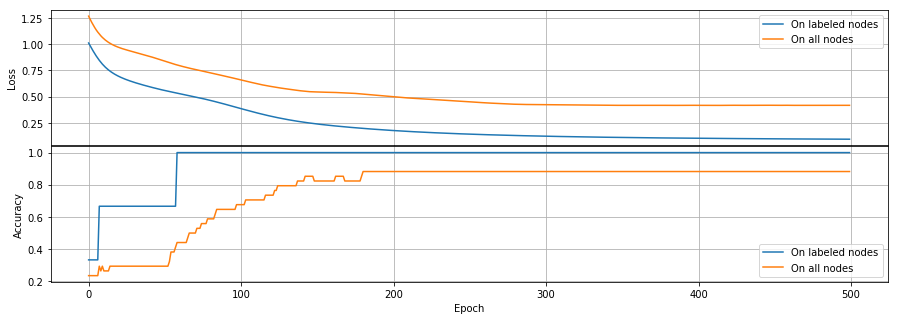

In [12]:


input_size = adj_matrix.shape[0]
hidden_size_1 = 16
embedding_size = 2
output_size = 3

y_real = torch.Tensor(classes).long().to(device)
y_selected_real = y_real[mask]

embeddings = []

model = nn.Sequential(GraphLayer(adj_matrix, input_size, hidden_size_1),
                      nn.ReLU(),
                      GraphLayer(adj_matrix, hidden_size_1, embedding_size),
                      nn.Tanh(),
                      SaveLayer(embeddings),
                      GraphLayer(adj_matrix,embedding_size,output_size)).to(device)

inputs = torch.eye(input_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01,weight_decay=5e-3)

N_EPOCHS = 500
losses = np.zeros(N_EPOCHS)
total_losses = np.zeros(N_EPOCHS)
accuracies = np.zeros(N_EPOCHS)
total_accuracies = np.zeros(N_EPOCHS)


for epoch in range(N_EPOCHS):
    if((epoch+1)%200==0):
        print("Epoch [{}/{}] ".format(epoch+1,N_EPOCHS),end="\r")

    model.zero_grad()
    
    y_pred = model(inputs)
    y_selected_pred = y_pred[mask]

    loss = criterion(y_selected_pred,y_selected_real)
    
    with torch.no_grad():
        loss2 = criterion(y_pred,y_real)
    loss.backward()
    optimizer.step()
    
    losses[epoch] = loss.item()
    total_losses[epoch] = loss2.item()
    
    total_preds = np.argmax(y_pred.cpu().detach().numpy(),axis=1)
    total_reals = y_real.cpu().detach().numpy()
    
    preds = np.argmax(y_selected_pred.cpu().detach().numpy(),axis=1)
    reals = y_selected_real.cpu().detach().numpy()
    
    total_accuracies[epoch] = np.sum(total_preds == total_reals)/len(total_preds)
    accuracies[epoch] = np.sum(preds == reals)/len(preds)
    
fig, (ax1,ax2) = plt.subplots(nrows=2,sharex=True,figsize=(15,5))
fig.subplots_adjust(hspace=0.008)

ax1.plot(losses,label="On labeled nodes")
ax1.plot(total_losses,label="On all nodes")
ax1.legend()
ax1.grid()
ax1.set_ylabel("Loss")

ax2.plot(accuracies,label="On labeled nodes")
ax2.plot(total_accuracies,label="On all nodes")
ax2.legend()
ax2.grid()
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
plt.savefig("loss_accuracy_original.pdf")
plt.show()

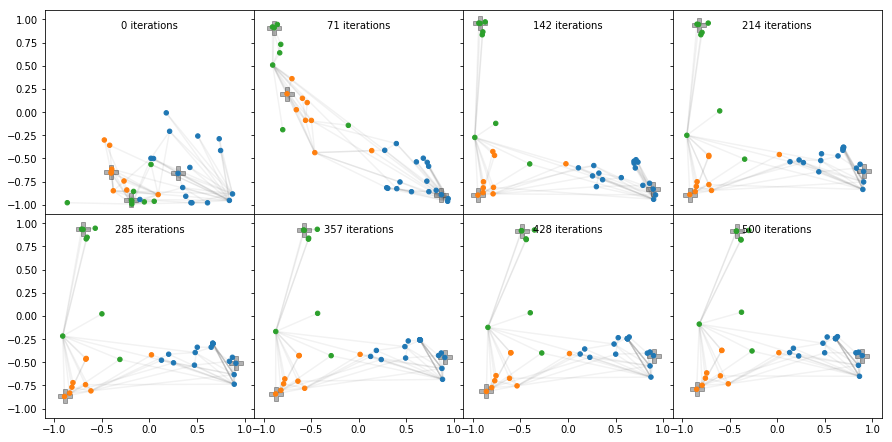

In [5]:
plot_embeddings(embeddings)
plt.savefig("embeddings_original.pdf")
plt.show()


<h2><center>Adding attention to the model

In [69]:
#norma...
class AttentionGraphLayer(nn.Module):
    def __init__(self,adjacency_matrix,input_size,output_size):
        super(AttentionGraphLayer,self).__init__()

        Ahat = adjacency_matrix + np.eye(len(adjacency_matrix))
        Dhat = np.diag(1/np.sqrt(np.sum(Ahat,axis=0)))
        
        self.M = torch.tensor(Dhat@Ahat@Dhat,requires_grad=False).float()
        self.W = nn.Parameter(torch.randn(input_size,output_size).float())
        self.Att = nn.Parameter(torch.randn(len(adjacency_matrix),len(adjacency_matrix)).float())
        
    def forward(self,X):

        self.Att_Dhat = torch.diag(1/torch.sqrt(torch.sum(self.Att,dim=0)))
        self.Att_norm = self.Att_Dhat @ self.Att @ self.Att_Dhat
        print(self.Att_norm)
        return self.Att_norm @ self.M @ X @ self.W  # X has dimensions (batch_size,node_index,data)

In [63]:
#norma...
class AttentionGraphLayer(nn.Module):
    def __init__(self,adjacency_matrix,input_size,output_size):
        super(AttentionGraphLayer,self).__init__()

        Ahat = adjacency_matrix + np.eye(len(adjacency_matrix))
        Dhat = np.diag(1/np.sqrt(np.sum(Ahat,axis=0)))
        
        self.M = torch.tensor(Dhat@Ahat@Dhat,requires_grad=False).float()
        self.W = nn.Parameter(torch.randn(input_size,output_size).float())
        self.Att = nn.Parameter(torch.randn(len(adjacency_matrix),len(adjacency_matrix)).float())
        
    def forward(self,X):

        self.Att_adj = self.Att @ self.M
        self.Att_Dhat = torch.diag(1/torch.sqrt(torch.sum(self.Att_adj,dim=0)))
        self.Att_adj_norm = self.Att_Dhat @ self.Att_adj @ self.Att_Dhat
        print(self.Att_adj_norm)
        return self.Att_adj_norm @ X @ self.W  # X has dimensions (batch_size,node_index,data)
    


In [107]:
class AttentionGraphLayer(nn.Module):
    def __init__(self,adjacency_matrix,input_size,output_size):
        super(AttentionGraphLayer,self).__init__()

        self.Ahat = torch.from_numpy(adjacency_matrix + np.eye(len(adjacency_matrix))).float()
        self.W = nn.Parameter(torch.randn(input_size,output_size).float())
        self.Att = nn.Parameter(torch.randn(len(adjacency_matrix),len(adjacency_matrix)).float())
        
    def forward(self,X):
        self.Att_adj = self.Att @ self.Ahat
        self.Dhat = torch.diag(1/torch.sqrt(torch.sum(self.Att_adj,dim=0)))
        self.Att_adj_norm = self.Dhat@self.Att_adj@ self.Dhat
        print('grad=',self.Att.grad)
        print('att_matrix=', self.Att )
        return self.Att_adj_norm @ X @ self.W  # X has dimensions (batch_size,node_index,data)

In [228]:
class AttentionGraphLayer(nn.Module):
    def __init__(self,adjacency_matrix,input_size,output_size):
        super(AttentionGraphLayer,self).__init__()

        #self.Ahat = torch.from_numpy(adjacency_matrix + np.eye(len(adjacency_matrix))).float()
        self.Ahat = torch.from_numpy(adjacency_matrix).float()
        self.W = nn.Parameter(torch.randn(input_size,output_size).float())
        
    def forward(self,X,Att):
        
        self.Att_adj = torch.diag(Att) @ self.Ahat
        self.Dhat = torch.diag(1/torch.sqrt(torch.sum(self.Att_adj,dim=0)))
        self.Att_adj_norm = self.Dhat@self.Att_adj@ self.Dhat
        return self.Att_adj_norm @ X @ self.W  # X has dimensions (batch_size,node_index,data)

In [231]:
class gcn_1(nn.Module):
    def __init__(self, adjacency_matrix):
        super(gcn_1,self).__init__()
        
        self.adjacency_matrix = adjacency_matrix
        self.graphlayer1 = AttentionGraphLayer(adj_matrix, input_size, hidden_size_1)
        self.graphlayer2 = GraphLayer(adj_matrix, hidden_size_1, embedding_size)
        self.graphlayer3 = GraphLayer(adj_matrix,embedding_size,output_size)
        
    def forward(self,X, Att):
        X = torch.relu(self.graphlayer1(X, Att))
        X_embedding = torch.tanh(self.graphlayer2(X))
        X = F.softmax(self.graphlayer3(X_embedding), dim=1)
        return X

In [ ]:
input_size = adj_matrix.shape[0]
hidden_size_1 = 16
embedding_size = 2
output_size = 3
embeddings2 = []
N_EPOCHS = 10000


'''
attmodel = nn.Sequential( AttentionGraphLayer(adj_matrix, input_size, hidden_size_1),
                          nn.ReLU(),
                          AttentionGraphLayer(adj_matrix, hidden_size_1, embedding_size),
                          nn.Tanh(),
                          SaveLayer(embeddings2),
                          AttentionGraphLayer(adj_matrix,embedding_size,output_size))
'''



inputs = torch.eye(input_size)
attmodel = gcn_1(inputs)
Att = nn.Parameter(torch.randn(input_size).float())
#Att = torch.tensor([1.0])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(attmodel.parameters(),lr=0.001,weight_decay=5e-5)


losses = np.zeros(N_EPOCHS)
total_losses = np.zeros(N_EPOCHS)
accuracies = np.zeros(N_EPOCHS)
total_accuracies = np.zeros(N_EPOCHS)


for epoch in range(N_EPOCHS):
    if((epoch+1)%200==0):
        print("Epoch [{}/{}] ".format(epoch+1,N_EPOCHS),end="\r")

    attmodel.zero_grad()
    
    y_pred = attmodel(inputs, Att)
    y_selected_pred = y_pred[mask]

    loss = criterion(y_selected_pred,y_selected_real)
    
    with torch.no_grad():
        loss2 = criterion(y_pred,y_real)
    loss.backward()
    optimizer.step()
    
    losses[epoch] = loss.item()
    total_losses[epoch] = loss2.item()
    
    total_preds = np.argmax(y_pred.detach().numpy(),axis=1)
    total_reals = y_real.detach().numpy()
    
    preds = np.argmax(y_selected_pred.detach().numpy(),axis=1)
    reals = y_selected_real.detach().numpy()
    
    total_accuracies[epoch] = np.sum(total_preds == total_reals)/len(total_preds)
    accuracies[epoch] = np.sum(preds == reals)/len(preds)
    
fig, (ax1,ax2) = plt.subplots(nrows=2,sharex=True,figsize=(15,5))
fig.subplots_adjust(hspace=0.008)

ax1.plot(losses,label="On labeled nodes")
ax1.plot(total_losses,label="On all nodes")
ax1.legend()
ax1.grid()
ax1.set_ylabel("Loss")

ax2.plot(accuracies,label="On labeled nodes")
ax2.plot(total_accuracies,label="On all nodes")
ax2.legend()
ax2.grid()
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
plt.savefig("loss_accuracy_attention.pdf")
plt.show()


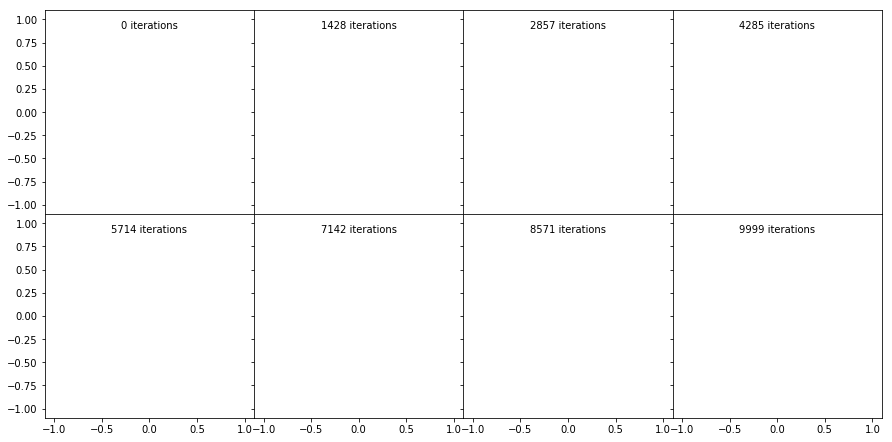

In [58]:
plot_embeddings(embeddings2)
plt.savefig("embeddings_attention.pdf")
plt.show()


<h2><center>Adding the Tradeoff Parameter

In [189]:
class TradeoffGraphLayer(nn.Module):
    def __init__(self,adjacency_matrix,input_size,output_size,tradeoff_param_save=None):
        super(TradeoffGraphLayer,self).__init__()
        
        self.tradeoff_param_save = tradeoff_param_save
        self.A = torch.Tensor(adjacency_matrix)
        self.tradeoff_param = nn.Parameter(torch.randn(1),requires_grad=True)
        self.W = nn.Parameter(torch.randn(input_size,output_size,requires_grad=True).float())
        
    def forward(self,X):        
        Ahat = self.A + self.tradeoff_param*torch.eye(len(self.A))
        
        self.tradeoff_param_save.append(float(self.tradeoff_param.detach().numpy()[0]))

        Dhat = torch.diag(1/torch.sqrt(torch.sum(Ahat,dim=0))).float()
        return Dhat @ Ahat @ Dhat @  X @ self.W  # X has dimensions (batch_size,node_index,data)

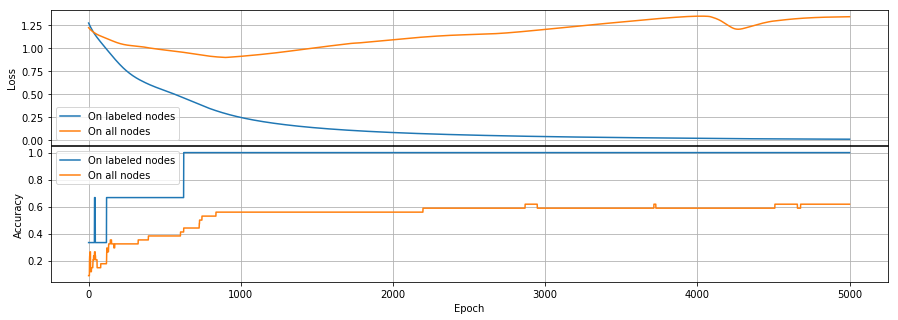

In [190]:
input_size = adj_matrix.shape[0]
hidden_size_1 = 16
embedding_size = 2
output_size = 3
embeddings3 = []

lambdas = [[],[],[]]

N_EPOCHS = 5000

tradeoffmodel = nn.Sequential(TradeoffGraphLayer(adj_matrix, input_size, hidden_size_1,lambdas[0]),
                              nn.ReLU(),
                              TradeoffGraphLayer(adj_matrix, hidden_size_1, embedding_size,lambdas[1]),
                              nn.Tanh(),
                              SaveLayer(embeddings3),
                              TradeoffGraphLayer(adj_matrix,embedding_size,output_size,lambdas[2]))

inputs = torch.eye(input_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(tradeoffmodel.parameters(),lr=0.001,weight_decay=5e-5)

losses = np.zeros(N_EPOCHS)
total_losses = np.zeros(N_EPOCHS)
accuracies = np.zeros(N_EPOCHS)
total_accuracies = np.zeros(N_EPOCHS)


for epoch in range(N_EPOCHS):
    print("Epoch [{}/{}] ".format(epoch+1,N_EPOCHS),end="\r")

    tradeoffmodel.zero_grad()
    
    y_pred = tradeoffmodel(inputs)
    y_selected_pred = y_pred[mask]

    loss = criterion(y_selected_pred,y_selected_real)
    
    with torch.no_grad():
        loss2 = criterion(y_pred,y_real)
    loss.backward()
    optimizer.step()
    
    losses[epoch] = loss.item()
    total_losses[epoch] = loss2.item()
    
    total_preds = np.argmax(y_pred.detach().numpy(),axis=1)
    total_reals = y_real.detach().numpy()
    
    preds = np.argmax(y_selected_pred.detach().numpy(),axis=1)
    reals = y_selected_real.detach().numpy()
    
    total_accuracies[epoch] = np.sum(total_preds == total_reals)/len(total_preds)
    accuracies[epoch] = np.sum(preds == reals)/len(preds)
    
fig, (ax1,ax2) = plt.subplots(nrows=2,sharex=True,figsize=(15,5))
fig.subplots_adjust(hspace=0.008)

ax1.plot(losses,label="On labeled nodes")
ax1.plot(total_losses,label="On all nodes")
ax1.legend()
ax1.grid()
ax1.set_ylabel("Loss")

ax2.plot(accuracies,label="On labeled nodes")
ax2.plot(total_accuracies,label="On all nodes")
ax2.legend()
ax2.grid()
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")

plt.show()



NameError: name 'labeled_nodes' is not defined

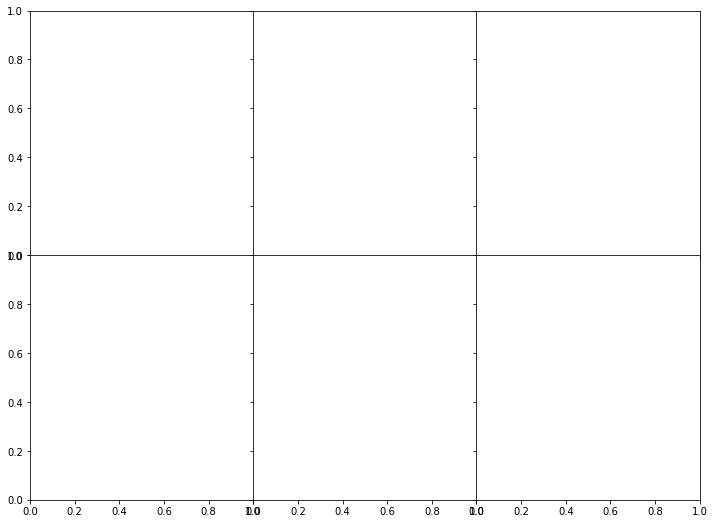

In [191]:
marker = "P"
marker_size = 200
marker_alpha = 0.3
window_size = 1.1



#produce subplots with shared axes
fig, axes = plt.subplots(2,3, sharex=True, sharey=True,figsize=(8*1.5,6*1.5))
fig.subplots_adjust(wspace=0,hspace=0)

for i, ax in enumerate(axes.flatten()):
    for l_node in labeled_nodes:
        time = int(len(embeddings3)*i/(3*2))
        ax.scatter(embeddings3[time][l_node,0],embeddings3[time][l_node,1],
                   color="k",s=marker_size,alpha=marker_alpha,marker=marker)
        
    for node1 in range(len(adj_matrix)):
        for node2 in range(node1,len(adj_matrix)):
            if node1 != node2:
                if adj_matrix[node1,node2] != 0:
                    ax.plot([embeddings3[time][node1,0],embeddings3[time][node2,0]],
                            [embeddings3[time][node1,1],embeddings3[time][node2,1]],
                            color="k",zorder=0,alpha=0.05)
                
    ax.scatter(embeddings3[time][:,0],embeddings3[time][:,1],color=community_colors,s=point_size)
    ax.text(0,0.9,str(time)+ " iterations",horizontalalignment='center')
    ax.set_xlim(-window_size,window_size)
    ax.set_ylim(-window_size,window_size)
#plt.tight_layout()
plt.show()


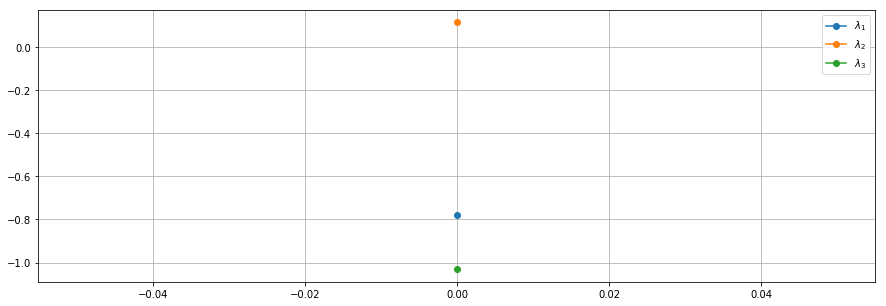

In [24]:
plt.figure(figsize=(15,5))
plt.plot(lambdas[0],'-o',label=r"$\lambda_1$")
plt.plot(lambdas[1],'-o',label=r"$\lambda_2$")
plt.plot(lambdas[2],'-o',label=r"$\lambda_3$")
plt.grid()
plt.legend()
plt.show()

In [25]:
lambdas

[[-0.7771985530853271,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  na